# Exercises 03: Deep Learning

In [0]:
import itertools

import argparse
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
BATCH_SIZE = 64 # 64
TEST_BATCH_SIZE = 1000 # 1000
LEARNING_RATE = 1
GAMMA = 0.7
RANDOM_SEED = 1

Images is tensor of shape: torch.Size([64, 1, 28, 28]), labels is tensor of shape: torch.Size([64])
Images:


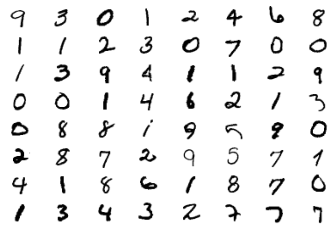

Labels:
9,3,0,1,2,4,6,8,
1,1,2,3,0,7,0,0,
1,3,9,4,1,1,2,9,
0,0,1,4,6,2,1,3,
0,8,8,1,9,5,9,0,
2,8,7,2,9,5,7,1,
4,1,8,6,1,8,7,0,
1,3,4,3,2,7,7,7,


In [56]:
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)


train_iter = iter(train_loader)
test_iter = iter(test_loader)
images, labels = train_iter.next()
print(f'Images is tensor of shape: {images.shape}, labels is tensor of shape: {labels.shape}')
figure = plt.figure()
num_of_images = 64
for index in range(1, num_of_images + 1):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')
print("Images:")
plt.show()
print("Labels:")
for i in range(8):
    for j in range(8):
        print(labels[i*8+j].item(), end=',')
    print()

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [0]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.067521
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.047243
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.054840
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.068377
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.055667
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.171844
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.052937
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.104444
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.095433
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.078791

Test set: Average loss: 753.3608, Accuracy: 9774/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
Images:


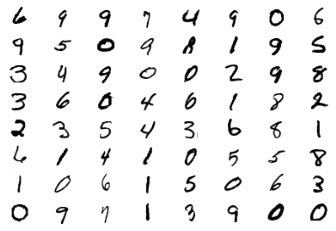

Preds:
6,9,9,7,4,9,0,6,
9,5,0,9,8,1,9,5,
3,4,9,0,0,2,9,8,
3,6,0,4,6,1,8,2,
2,3,5,4,3,6,8,1,
6,1,4,1,0,5,5,8,
1,0,6,1,5,0,6,3,
0,9,7,1,3,9,0,0,


In [60]:
EPOCHS = 1
ITER_PER_EPOCH = 1000
TEST_ITER_PER_EPOCH = len(test_loader)
LOG_INTERVAL = 100


for epoch in range(EPOCHS):
    train_iter = itertools.cycle(iter(train_loader))
    test_iter =  iter(test_loader)

    for batch_idx in range(ITER_PER_EPOCH):
        (data, target) = next(train_iter)
        #for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    test_loss = 0
    total = 0
    correct = 0
    images = None
    preds = None
    with torch.no_grad():
        for batch_idx in range(TEST_ITER_PER_EPOCH):
            (data, target) = next(test_iter)

            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.shape[0]
            images = data.cpu()
            preds = pred.cpu().numpy()
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, total,
            100. * correct / total))

    print(f'Images is tensor of shape: {images.shape}, preds is tensor of shape: {preds.shape}')
    figure = plt.figure()
    num_of_images = 64
    for index in range(num_of_images):
        plt.subplot(8, 8, index+1)
        plt.axis('off')
        plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    print("Images:")
    plt.show()
    print("Preds:")
    for i in range(8):
        for j in range(8):
            print(preds[i*8+j].item(), end=',')
        print()

## Exercise 1
Change the above to use [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) as an optimizer and try to retrain the model. How does the accuracy change? Can you improve accuracy by modifying the learning rate?

Answer:

LEARNING_RATE = 0.001
...
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


## Exercise 2
Can you add a plot which shows loss over time? Can you add a second plot which shows test accuracy over multiple epochs?

Note: you can modify the "EPOCHS" constant to increase the number of epochs executed

## Exercise 3
Try increase / reduce the amount of dropout on the model. How does this affect the accuracy? 